Modal SNA MAP473D, Ecole Polytechnique, 2022-23

# TP5 - Méthodes adaptatives multi-niveaux (AMS)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps
from time import perf_counter, sleep
from IPython.display import clear_output
plt.rcParams['figure.figsize'] = [10,7]


## Exercice 1 : le cadre statique

On reprend l'exemple jouet du TP2. Pour un seuil $q$ donné, on veut appliquer l'algorithme de la dernière particule pour estimer la probabilité $p:=\mathbb{P}(\mathcal{N}(0,1)>q)$, avec typiquement $p$ très faible. Pour cela, il suffit de disposer d'un noyau de transition $P$ réversible pour la loi $\mathcal{N}(0,1)$, par exemple le noyau gaussien vu en TP2. Partant de $X$, ce noyau propose une transition en $\rho X+\sqrt{1-\rho^2}W$, avec $W\sim\mathcal{N}(0,1)$ indépendante de $X$ et $\rho\in]0,1[$ un paramètre de réglage. 

Pour un niveau $L$ donné, si $X\sim\mathcal{N}(0,1)|\mathcal{N}(0,1)>L$, alors
\begin{equation*}
X':= \begin{cases}\rho X+\sqrt{1-\rho^2} W &\textrm{ si $\rho X+\sqrt{1-\rho^2} W>L$}\\ X&\textrm{ sinon}\end{cases} 
\end{equation*}
vérifie encore $X'\sim\mathcal{N}(0,1)|\mathcal{N}(0,1)>L$. Si l'on applique un "grand" nombre $T$ de fois ce noyau, on obtient donc un nouveau point toujours distribué selon la loi $\mathcal{N}(0,1)|\mathcal{N}(0,1)>L$ et "presque indépendant" du point initial $X$.

Rappelons le principe de l'algorithme : on part d'un échantillon de taille $n$ i.i.d. selon la loi $\mathcal{N}(0,1)$ et, à chaque itération, on calcule le score $L$ de la particule la moins intéressante (i.e. le minimum), on élimine cette dernière, on clone l'une des $(n-1)$ autres (choisie uniformément au hasard), clone auquel on applique $T$ fois le noyau précédent, et ainsi de suite jusqu'à l'itération $J_n:= \max \{j: L_j  \leq q \}$. L'estimateur de $p$ est alors tout simplement :
$$\hat p_n:=\left(1-\frac{1}{n}\right)^{J_n}.$$
Dans un cadre "idéalisé", on appliquerait un nombre infini de fois le noyau à chaque étape et on aurait alors le résultat de normalité asymptotique suivant :
$$\sqrt{n}\left(\hat p_n-p\right)\xrightarrow[n\to\infty]{\textrm{loi}}\mathcal{N}(0,-p^2\log p),$$
dont on déduit facilement des intervalles de confiance asymptotiques pour $p$.  

#### Question 1.1 ####
Implémenter la méthode ci-dessus pour estimer $p:=\mathbb{P}(\mathcal{N}(0,1)>q)$, ainsi qu'un intervalle de confiance asymptotique à $95\%$. On pourra prendre $q=6$, $n=100$, $\rho=0.9$ et $T=20$.

In [3]:
n = 1000
rho = 0.9
T = 20
q = 6
alpha = 0.05
p = sps.norm.sf(q)

def noyau(l,rho,T,Xnew):
    gauss = np.sqrt(1-rho**2)*sps.norm.rvs(size=T)
    for it in range(T):
        Y = rho*Xnew+gauss[it]
        if(Y>l): Xnew = Y
    return Xnew

t0 = perf_counter()
X = sps.norm.rvs(size=n)
L = min(X)
I = np.argmin(X)
J = 0

while L<q:
    Iprime = I
    while(Iprime == I):
        Iprime = np.random.randint(n)
    X[I] = noyau(L,rho,T,X[Iprime])
    L = min(X)
    I = np.argmin(X)
    J = J+1
    
phat = (1-1/n)**J
borneinf = phat - sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)
bornesup = phat + sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"La vraie probabilité est {p:1.2e}")
print(f"Son estimation est : {phat:1.2e}")
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2e},{bornesup:1.2e}]")

Durée (s) : 1.6
La vraie probabilité est 9.87e-10
Son estimation est : 9.30e-10
Intervalle de confiance asymptotique : [6.67e-10,1.19e-09]


#### Question 1.2 ####
En utilisant par exemple un histogramme, comparer la distribution empirique de l'échantillon des points $X_i$ obtenu en dernière étape à la densité d'une loi $\mathcal{N}(0,1)$ conditionnée à être supérieure à $q$. On pourra prendre $n=1000$ dans le code précédent et les mêmes valeurs pour les autres paramètres.

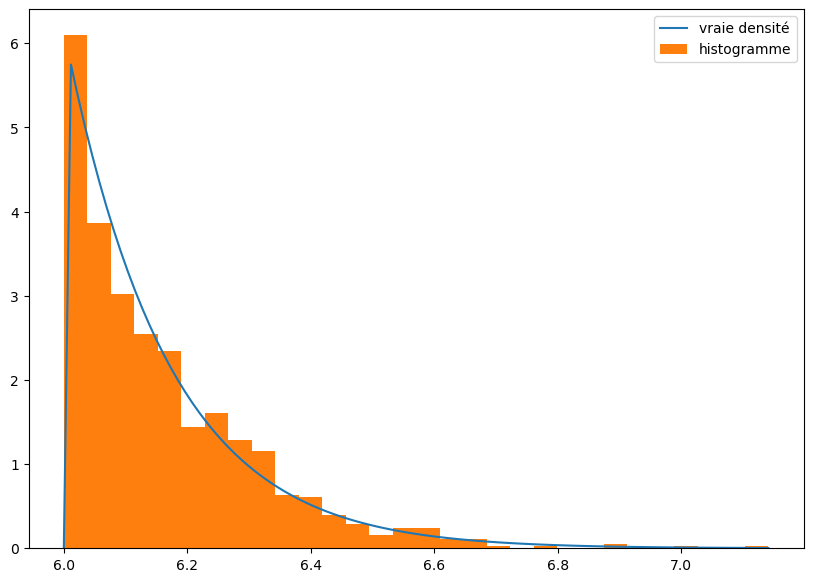

In [5]:
def normsupq(x,q,p):
    return sps.norm.pdf(x)*(x>q)/p

x_pdf = np.linspace(q, max(X), num=100)

plt.plot(x_pdf, normsupq(x_pdf,q,p), label="vraie densité")
plt.hist(X,bins='auto',density=True, label="histogramme")
plt.legend();

#### Question 1.3 ####
On souhaite vérifier la pertinence du TCL du cadre idéal. Pour cela, effectuer par exemple $N=100$ fois la procédure précédente pour obtenir un échantillon de $N$ valeurs de $\hat p_n$. Comparer l'écart-type empirique de cet échantillon à l'écart-type théorique du cadre idéal. En utilisant par exemple la fonction `sps.gaussian_kde()`, comparer la distribution empirique de cet échantillon convenablement centré et renormalisé à celle d'une loi $\mathcal{N}(0,1)$. On pourra prendre $q=3$, $n=100$, $\rho=0.9$ et $T=20$. 

Durée (s) : 3.1
La vraie probabilité est 1.35e-03
L'écart-type empirique est 3.22e-04
L'écart-type théorique du cadre idéal est 3.47e-04


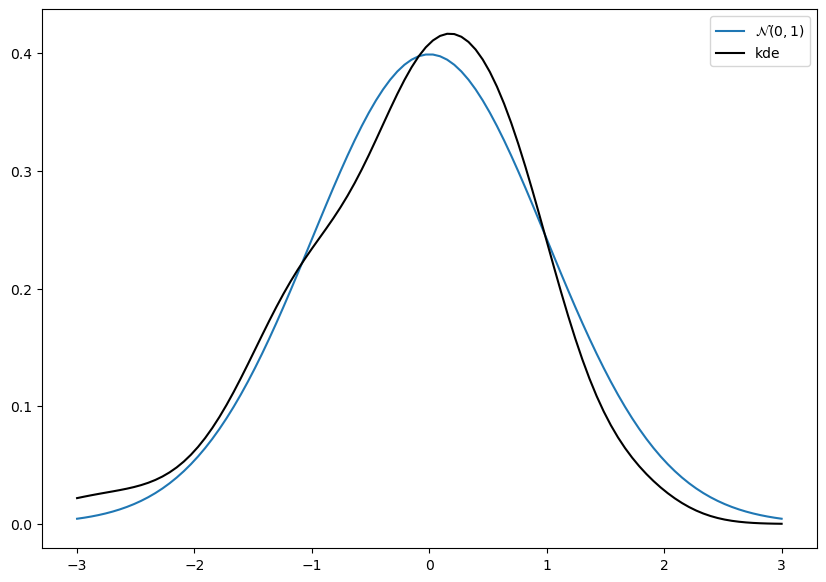

In [9]:
N = 100
n = 100
rho = 0.9
T = 20
q = 3
p = sps.norm.sf(q)

t0 = perf_counter()
phat = np.zeros(N)

def noyau(l,rho,T,Xnew):
    gauss = np.sqrt(1-rho**2)*sps.norm.rvs(size=T)
    for it in range(T):
        Y = rho*Xnew+gauss[it]
        if(Y>l): Xnew = Y
    return Xnew

for it in range(N):
    X = sps.norm.rvs(size=n)
    L = min(X)
    I = np.argmin(X)
    J = 0

    while L<q:
        Iprime = I
        while(Iprime == I):
            Iprime = np.random.randint(n)
        X[I] = noyau(L,rho,T,X[Iprime])
        L = min(X)
        I = np.argmin(X)
        J = J+1
            
    phat[it] = (1-1/n)**J
    
sdempirique = np.std(phat)  
sdtheorique = np.sqrt(-p**2*np.log(p)/n)


print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"La vraie probabilité est {p:1.2e}")
print(f"L'écart-type empirique est {sdempirique:1.2e}")
print(f"L'écart-type théorique du cadre idéal est {sdtheorique:1.2e}")


phatnorm = np.sqrt(n)*(phat-p)/(phat*np.sqrt(-np.log(phat)))
kde = sps.gaussian_kde(phatnorm)
x_pdf = np.linspace(-3, 3, num=100)

plt.plot(x_pdf, sps.norm.pdf(x_pdf), label=r"$\mathcal{N}(0,1)$")
plt.plot(x_pdf, kde(x_pdf), color="black", label="kde")
# plt.hist(kde(x_pdf),bins='auto',density=True, label="histogramme")

plt.legend();

#### Question 1.4 ####
On souhaite désormais estimer le quantile d'ordre $(1-p)$ c'est-à-dire, pour une valeur $p$ donnée, déterminer $q$ tel que $\mathbb{P}(\mathcal{N}(0,1)>q)=p$. Il suffit d'appliquer l'algorithme précédent jusqu'à l'itération $j_n:= \lceil \frac{\log p}{\log (1-n^{-1})}\rceil$ et poser 
$$\hat q_n:=L_{j_n}.$$
Dans un cadre "idéalisé", on appliquerait un nombre infini de fois le noyau à chaque étape et on aurait alors le résultat de normalité asymptotique suivant (en notant $\varphi$ la densité de la loi $\mathcal{N}(0,1))$ :
$$\sqrt{n}(\hat{q}_n-q)\xrightarrow[n\to\infty]{d}\mathcal{N}\left(0,\frac{-p^2\log p}{\varphi(q)^2}\right).$$
En notant
$$\hat\sigma_n:=\frac{p\sqrt{-\log p}}{\varphi(\hat{q}_n)},$$
ceci permet d'en déduire des intervalles de confiance asymptotiques. 

Implémenter cet algorithme pour estimer le quantile $q$ tel que $\mathbb{P}(\mathcal{N}(0,1)>q)=p$, ainsi qu'un intervalle de confiance asymptotique à $95\%$ issu de la convergence en loi ci-dessus. On pourra prendre $p=10^{-6}$, $n=100$, $\rho=0.9$ et $T=20$.

In [10]:
n = 1000
rho = 0.9
T = 20
p = 10**(-6)
alpha = 0.05
q = sps.norm.ppf(1-p)
jn = int(np.ceil(np.log(p)/np.log(1-1/n)))

def noyau(l,rho,T,Xnew):
    gauss = np.sqrt(1-rho**2)*sps.norm.rvs(size=T)
    for it in range(T):
        Y = rho*Xnew+gauss[it]
        if(Y>l): Xnew = Y
    return Xnew

t0 = perf_counter()
X = sps.norm.rvs(size=n)
L = min(X)
I = np.argmin(X)

for j in range(1,1+jn):
    Iprime = I
    while(Iprime == I):
        Iprime = np.random.randint(n)
    X[I] = noyau(L,rho,T,X[Iprime])
    L = min(X)
    I = np.argmin(X)
        
qhat = L
sigmahat = p*np.sqrt(-np.log(p))/sps.norm.pdf(qhat)

borneinf = qhat - sps.norm.ppf(1-alpha/2)*sigmahat/np.sqrt(n)
bornesup = qhat + sps.norm.ppf(1-alpha/2)*sigmahat/np.sqrt(n)

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"Le vrai quantile est {q:1.2f}")
print(f"Son estimation est {qhat:1.2f}")
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2f},{bornesup:1.2f}]")

Durée (s) : 1.3
Le vrai quantile est 4.75
Son estimation est 4.71
Intervalle de confiance asymptotique : [4.67,4.75]


#### Question 1.5 ####
En général, on ne connaît pas la densité $\varphi(q)$ apparaissant au dénominateur du TCL
$$\sqrt{n}(\hat{q}_n-q)\xrightarrow[n\to\infty]{d}\mathcal{N}\left(0,\frac{-p^2\log p}{\varphi(q)^2}\right).$$
Dans ce cas, on a vu en Amphi 4 que si
$$j_n^\pm:= -n\log p\pm1.96\sqrt{-n\log p}$$
alors un IC de niveau asymptotique $95\%$ est 
$$\left[L_{\lfloor j_n^-\rfloor},L_{\lceil j_n^+\rceil}\right].$$
Pour cela, effectuer par exemple $N=100$ fois la procédure précédente pour obtenir $N$ intervalles de confiance de niveau asymptotique $95\%$. Afficher le pourcentage de fois où la vraie valeur de $q$ est dans l'intervalle de confiance. 

In [11]:
N = 100
n = 100
rho = 0.9
T = 20
q = 3
p = sps.norm.sf(q)
alpha = 0.05
jn = int(np.ceil(np.log(p)/np.log(1-1/n)))
jnmoins = int(np.floor(-n*np.log(p)-sps.norm.ppf(1-alpha/2)*np.sqrt(-n*np.log(p))))
jnplus = int(np.ceil(-n*np.log(p)+sps.norm.ppf(1-alpha/2)*np.sqrt(-n*np.log(p))))


t0 = perf_counter()
qhat = np.zeros(N)
qhatmoins = np.zeros(N)
qhatplus = np.zeros(N)
compteurIC = 0

def noyau(l,rho,T,Xnew):
    gauss = np.sqrt(1-rho**2)*sps.norm.rvs(size=T)
    for it in range(T):
        Y = rho*Xnew+gauss[it]
        if(Y>l): Xnew = Y
    return Xnew

for it in range(N):
    X = sps.norm.rvs(size=n)
    L = min(X)
    I = np.argmin(X)

    for j in range(1,1+jnmoins):
        Iprime = I
        while(Iprime == I):
            Iprime = np.random.randint(n)
        X[I] = noyau(L,rho,T,X[Iprime])
        L = min(X)
        I = np.argmin(X)
        
    qhatmoins[it] = L 
        
    for j in range(1+jnmoins,1+jnplus):
        Iprime = I
        while(Iprime == I):
            Iprime = np.random.randint(n)
        X[I] = noyau(L,rho,T,X[Iprime])
        L = min(X)
        I = np.argmin(X)    
        
    qhatplus[it] = L
    
    if q > qhatmoins[it] and q < qhatplus[it]:
       compteurIC = compteurIC+1
        
proportion = 100 * compteurIC/N

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"Pourcentage de fois où le quantile est dans l'IC : {proportion}")

Durée (s) : 3.5
Pourcentage de fois où le quantile est dans l'IC : 94.0


## Exercice 2 : le cadre dynamique

On considère un processus stochastique en dimension 1 :
$$dX(t)=-V'(X(t)) dt + \sqrt{2 \varepsilon}\ dB(t)$$
où $V:\mathbb R \to \mathbb R$ est une fonction potentielle, $\varepsilon >0$ fixe l'intensité du bruit et $(B(t))_{t \ge 0}$ est un mouvement brownien standard. Pour deux réels $a<b$, on note $\tau_a= \inf\{t \ge 0, X(t)<a\}$ et  $\tau_b= \inf\{t \ge 0, X(t)>b\}$. Pour une condition initiale $X(0)=x_0 \in (a,b)$ fixée, on souhaite évaluer
$$p=\mathbb P(\tau_b < \tau_a)$$
dans le cas où cette probabilité est très petite.

On introduit un pas de temps $\delta_t>0$ et la discrétisation suivante : pour tout $k \ge 0$,
$$X_{k+1} = X_k - V'(X_k) \delta_t + \sqrt{2 \varepsilon \delta_t}\ G_k$$
où $(G_k)_{k \ge 0}$ est une suite i.i.d. de gaussiennes centrées réduites. On considère donc des trajectoires $(X_k)_{0 \le k \le T_a \wedge T_b}$ où $T_a=\min\{k\ge 0, \, X_k < a\}$ et $T_b=\min\{k\ge 0, \, X_k > b\}$.

#### Question 2.0 #### 
Représenter la fonction potentielle $V(x)=\frac{x^4}{4}-\frac{x^2}{2}$ sur l'intervalle $[-1.5;1.5]$.

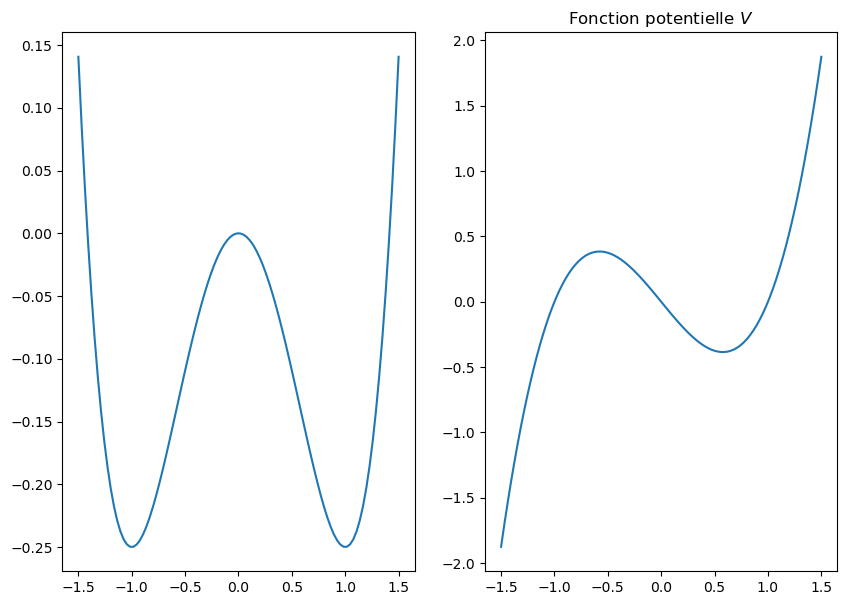

In [13]:
V= lambda x : x**4/4-x**2/2
Vprime= lambda x :x**3-x
     

x = np.linspace(-1.5, 1.5, num=100)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, V(x))
ax2.plot(x, Vprime(x))
plt.title("Fonction potentielle $V$");

#### Question 2.1 #### 
Simuler et afficher une trajectoire $(X_k)_{0 \le k \le T_a \wedge T_b}$ de cette dynamique pour la fonction potentielle $V$ ci-dessus et les paramètres suivants : $a=-0.9$, $b=0.9$, $x_0=-0.89$, $\varepsilon=0.02$, $\delta_t=0.001$. 

Maximum de la trajectoire : 4.288


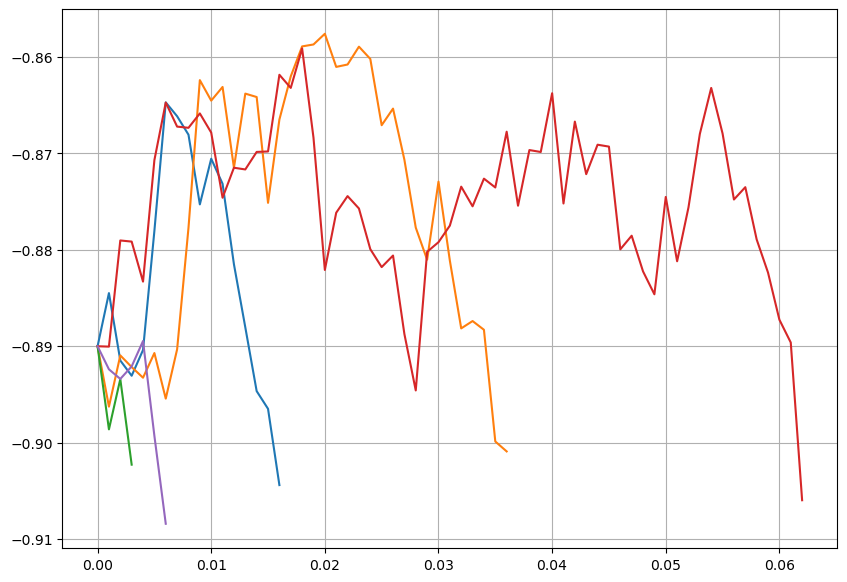

In [15]:
a = -0.9
b = 0.9
x0 = -0.89
epsilon = 0.02
dt = 0.001
sigma = np.sqrt(2*epsilon*dt)

# Simulation d'une trajectoire


def sim_traj(a, b, x0, epsilon, dt):
    X = [x0]
    sigma = np.sqrt(2 * epsilon * dt)
    while X[-1] >= a and X[-1] <= b:
        X.append(X[-1] - Vprime(X[-1]) * dt + sigma * sps.norm.rvs())
    X = np.asarray(X)
    return X

def plot_X(traj):
    l = traj.size
    temps = np.arange(l)*dt
    plt.plot(temps,traj)
    plt.grid()
for _ in range(5):
    plot_X(sim_traj(a,b,x0,epsilon,dt))

    
    
Xmax = X.max()
print(f"Maximum de la trajectoire : {Xmax:1.3f}")

#### Question 2.2 #### 
Estimer $p=\mathbb P(T_b<T_a)$ par un estimateur Monte-Carlo naïf (avec un intervalle de confiance de niveau asymptotique $95\%$), d'abord pour $\varepsilon=1$, puis pour $\varepsilon=0.02$. On pourra prendre un échantillon de taille $n=1000$.

In [16]:
epsilon = 1
alpha = 0.05
sigma = np.sqrt(2*epsilon*dt)
n = 1000 

t0 = perf_counter()
compteur = 0

for i in range(n):
    X = x0
    while X>=a and X<=b:
        X = X-Vprime(X)*dt+sigma*sps.norm.rvs()
    if X>b:
        compteur += 1
        
phat = compteur/n
rayon = sps.norm.ppf(1-alpha/2)*np.sqrt(phat*(1-phat)/n)
borneinf = phat-rayon
bornesup = phat+rayon

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"Estimation de la probabilité : {phat:1.2e}")
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2e},{bornesup:1.2e}]")

Durée (s) : 0.8
Estimation de la probabilité : 1.40e-02
Intervalle de confiance asymptotique : [6.72e-03,2.13e-02]


#### Question 2.3 #### 
Nous allons maintenant programmer l'algorithme AMS (Adaptive Multilevel Splitting) vu en cours, en commençant par l'initialisation qui correspond à :
* Construire une liste de $n$ trajectoires $(X^i_k)_{0 \le k \le T_a \wedge T_b}$, pour $0 \le i \le n-1$,
* Calculer le premier niveau $L_1=\min_{0 \le i \le n-1}\max_{0 \le k \le T_a \wedge T_b} X^i_k$,
* Déterminer l'ensemble des indices des trajectoire à tuer : $\mathcal K=\{0 \le i \le n-1,\ \max_{0 \le k \le T_a \wedge T_b}X^i_k=L_1\}$,
* Initialiser l'estimateur de la probabilité : $\hat p_n=1-\frac{|\mathcal K|}{n}$.

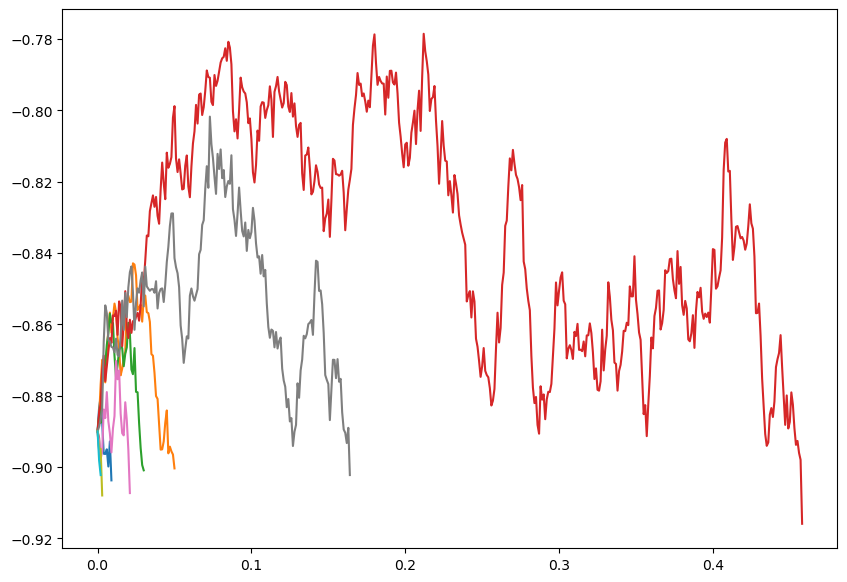

In [10]:
epsilon = 0.02
n = 10
sigma = np.sqrt(2*epsilon*dt)

X_AMS = []
p = 1

for i in range(n):
    X = [x0]
    while X[-1]>=a and X[-1]<=b:
        X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
    X = np.array(X)
    X_AMS.append(X)

# Calcul des maxima
S = np.zeros(n)
for i in range(n):
    S[i] = max(X_AMS[i])

L = np.min(S)   
K = np.argwhere(S==L).ravel()
p *= (1-K.size/n)
    
# Affichage
for i in range(n):
    plot_X(X_AMS[i]) 

#### Question 2.4 #### 
Programmer ensuite les itérations d'AMS c'est-à-dire, tant que $L \le b$ et pour chaque $i\in \mathcal K$ :
* Tirer un indice $I'$ au hasard parmi $\{0,\ldots,n-1\} \setminus \{\mathcal K\}$
* Recopier la trajectoire $X^{I'}$ sur $X^{i}$ jusqu'au premier indice $k$ où $X^{I'}_k> L$ (attention à l'inégalité stricte)
* Compléter cette trajectoire jusqu'à $T_a \wedge T_b$
* Mettre à jour $L$, $\mathcal K$ et l'estimateur $\hat p_n \leftarrow \left(1-\frac{|\mathcal K|}{n}\right)\hat p_n$

Faire des simulations avec $\varepsilon=1$ puis avec $\varepsilon=0.02$, et $n=100$. Pour l'intervalle de confiance asymptotique à 95%, on fera l'approximation selon laquelle une seule trajectoire est tuée à chaque itération, c'est-à-dire que comme dans l'exercice précédent
$$\sqrt{n}\left(\hat p_n-p\right)\xrightarrow[n\to\infty]{d}\mathcal{N}(0,-p^2\log p).$$

In [12]:
epsilon = 0.02
n = 100
sigma = np.sqrt(2*epsilon*dt)

X_AMS = []
phat = 1
t0 = perf_counter()


for i in range(n):
    X = [x0]
    while X[-1]>=a and X[-1]<=b:
        X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
    X = np.asarray(X)
    X_AMS.append(X)

S = np.zeros(n)
for i in range(n):
    S[i] = max(X_AMS[i])

L = np.min(S)   
K = np.argwhere(S==L).ravel()
phat *= (1-K.size/n)

while(L<=b):
    #print("niveau=",L)
    # Procédure de rééchantillonnage
    for i in K:
        Iprime = np.random.choice([i for i in range(n) if i not in K])
        n0 = np.argmax(X_AMS[Iprime]>L) # 1er temps où X dépasse L
        X_AMS[i] = list(X_AMS[Iprime][:n0+1])    
        while X_AMS[i][-1]>=a and X_AMS[i][-1]<=b:
            X_AMS[i].append(X_AMS[i][-1]-Vprime(X_AMS[i][-1])*dt+sigma*sps.norm.rvs())
        X_AMS[i] = np.array(X_AMS[i])
        S[i] = max(X_AMS[i])
    L = np.min(S)   
    K = np.argwhere(S==L).ravel()
    #print("K =",K)
    phat *= (1-K.size/n)
    # Affichage
#     clear_output(wait=True)
#     sleep(.2)
#     for i in range(n):
#         plot_X(X_AMS[i])
#     plt.show()
    
sigmahat = np.sqrt(-phat**2*np.log(phat)/n) 
alpha = 0.05
borneinf = phat - sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)
bornesup = phat + sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"L'estimation de la probabilité est {phat:1.2e}")
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2e},{bornesup:1.2e}]")

Durée (s) : 42.8
L'estimation de la probabilité est 2.21e-07
Intervalle de confiance asymptotique : [5.15e-08,3.91e-07]


#### Question 2.5 #### 
On peut montrer que, lorsque $\varepsilon$ tend vers $0$, la durée $D$ d'une trajectoire réactive suit approximativement la loi suivante
$$D\overset{loi}{\approx} G-\log\varepsilon+c$$
où $G$ suit une loi de Gumbel standard et
$$c=\log(0.89 × 0.9)−\frac{1}{2}\log(1 − 0.89^2)−\frac{1}{2}\log(1 − 0.9^2)$$

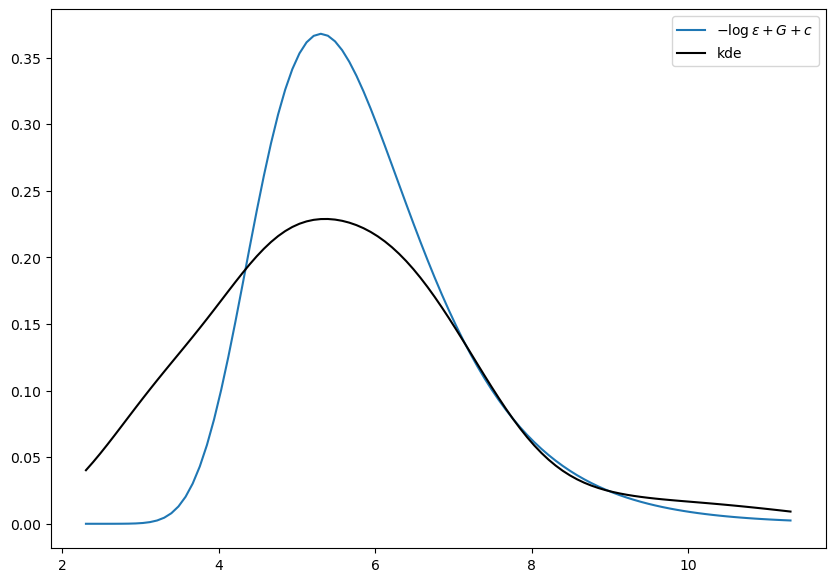

In [13]:
duree = np.zeros(n)
c = np.log(0.89*0.9)-0.5*np.log(1-0.89**2)-0.5*np.log(1-0.9**2)

for i in range(n):
    duree[i]=np.size(X_AMS[i])*dt

kde = sps.gaussian_kde(duree)
t = np.linspace(-3-np.log(epsilon)+c, 6-np.log(epsilon)+c, num=100)

plt.plot(t,sps.gumbel_r.pdf(t+np.log(epsilon)-c), label=r"$-\log\varepsilon+G+c$")
plt.plot(t, kde(t), color="black", label="kde")
plt.legend();

**Remarque** : Le résultat théorique de convergence en loi pour la durée d'une trajectoire réactive est prouvé dans l'article suivant :  
F. Cérou, A. Guyader, T. Lelièvre, and F. Malrieu, [On the Length of One-Dimensional Reactive Paths](https://perso.lpsm.paris/~aguyader/files/papers/cglm.pdf), *ALEA*, 2013.
